# Import Libraries

In [1]:
#!usr/bin/env python
#-*- coding:utf-8 -*-
from __future__ import division

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import math
from scipy.stats import norm, binom
from pandas_datareader.data import DataReader
import requests_cache
from copy import deepcopy


%matplotlib inline


# Pre-Question Data Retrieval/Cleaning/Calculations

## **Instantiate Given Information**

**Instantiate Number of Shares**
- N_aapl: Number of Apple shares
- N_dal: Number of Delta Airlines shares
- N_ccl: Number of Carnival Corporation shares
- N_total : Total number of shares

In [2]:
N_aapl = 200
N_dal = 1000
N_ccl = 1000
N_total = 200+1000+1000

**Instantiate Alpha and Confidence Level to calculate VaR**

In [3]:
alpha = 0.01
confidence = 0.99

## **Retrieving data**
- Time Period: 1st Jan 2019 till 31st Dec 2020 
- For Stocks: AAPL, DAL, CCL 
- Data Source: Yahoo Finance

**Defining method to obtain data**

In [4]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data_for_multiple_stocks(tickers,start_date,end_date):
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers:
        # get the data for the specific ticker
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
      
        s.insert(0, "Ticker", ticker)  #insert ticker column for better reference
        
        s['Prev Close'] = s['Adj Close'].shift(1) # Get previous adjusted close price
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close']) #calculate log returns
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1  #calculate percentage returns
        # add it to the dictionary
        stocks[ticker] = s
    # return the dictionary
    return stocks

**Retrieve Data for AAPL,DAL,CCL**
- Returns a dictionary of the stocks and their relevant information
- Time Period: 2019-01-01 to 2020-12-31

In [5]:
tickers = ['AAPL','DAL','CCL']
stocks =  get_data_for_multiple_stocks(tickers,start_date='2019-01-01',end_date= '2020-12-31')


**Creating Dataframe to combine data**

1. Create dataframes for individual stocks

In [6]:
aapl= stocks['AAPL'].reset_index()
aapl['Date'] = pd.to_datetime(aapl['Date'], infer_datetime_format=True) # Converting the date column to be recognised as datetime in pd

dal = stocks['DAL'].reset_index()
dal['Date'] = pd.to_datetime(dal['Date'], infer_datetime_format=True)

ccl = stocks['CCL'].reset_index()
ccl['Date'] = pd.to_datetime(ccl['Date'], infer_datetime_format=True)

# View Apple's dataframe
aapl.head(5)

,Date,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return
0,2018-12-31,AAPL,39.840000,39.119999,39.632500,39.435001,140014000.0,38.338482,NaN,NaN,NaN
1,2019-01-02,AAPL,39.712502,38.557499,38.722500,39.480000,148158800.0,38.382233,38.338482,0.001141,0.001141
2,2019-01-03,AAPL,36.430000,35.500000,35.994999,35.547501,365248800.0,34.559078,38.382233,-0.104924,-0.099607
3,2019-01-04,AAPL,37.137501,35.950001,36.132500,37.064999,234428400.0,36.034374,34.559078,0.041803,0.042689
4,2019-01-07,AAPL,37.207500,36.474998,37.174999,36.982498,219111200.0,35.954174,36.034374,-0.002228,-0.002226


2. Renaming Columns

In [7]:
# Rename Adjusted Close column
aapl.rename(columns={'Adj Close':'aapl Adj Close'}, inplace=True)
dal.rename(columns={'Adj Close':'dal Adj Close'}, inplace=True)
ccl.rename(columns={'Adj Close':'ccl Adj Close'}, inplace=True)

# Rename log returns column
aapl.rename(columns={'log_return':'aapl Log Return'}, inplace=True)
dal.rename(columns={'log_return':'dal Log Return'}, inplace=True)
ccl.rename(columns={'log_return':'ccl Log Return'}, inplace=True)

3. Create a new dataset with **adjusted close** and **log returns** of the stocks

In [8]:
dfs = [aapl, dal, ccl]
Stock_return = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
Stock_return = Stock_return[['Date','aapl Adj Close','dal Adj Close','ccl Adj Close', 'aapl Log Return','dal Log Return','ccl Log Return']]
Stock_return.dropna(inplace=True)
Stock_return.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return
1,2019-01-02,38.382233,48.430889,47.317497,0.001141,0.003800,0.011094
2,2019-01-03,34.559078,44.099277,44.963486,-0.104924,-0.093694,-0.051029
3,2019-01-04,36.034374,46.207077,47.507336,0.041803,0.046690,0.055033
4,2019-01-07,35.954174,46.265087,48.067360,-0.002228,0.001255,0.011719
5,2019-01-08,36.639568,45.897671,49.263351,0.018884,-0.007973,0.024577


## **Calculate Stock Weights**

1. Calculate Individual Stock Market Value 
- Market Value = Number of shares for each stock * Adjusted close for each stock

In [9]:
Stock_return['aapl Value'] = (N_aapl*Stock_return['aapl Adj Close'])
Stock_return['dal Value']  = (N_dal*Stock_return['dal Adj Close'])
Stock_return['ccl Value'] = (N_ccl*Stock_return['ccl Adj Close'])

2. Calculate Portfolio Value
- Portfolio Value = Market Value of AAPL + Market Value of DAL + Market Value of CCL

In [10]:
Stock_return['Portfolio Value'] = (N_aapl* Stock_return['aapl Adj Close'])+(N_dal*Stock_return['dal Adj Close'])+(N_ccl*Stock_return['ccl Adj Close'])

3. Calculate Stock Weights 
- Stock Weight = Stock Market Value/Portfolio Value

In [11]:
Stock_return['aapl Weight'] = Stock_return['aapl Value']/Stock_return['Portfolio Value']
Stock_return['dal Weight'] = Stock_return['dal Value']/Stock_return['Portfolio Value']
Stock_return['ccl Weight'] = Stock_return['ccl Value']/Stock_return['Portfolio Value']

# View Dataframe 
Stock_return.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight
1,2019-01-02,38.382233,48.430889,47.317497,0.001141,0.003800,0.011094,7676.446533,48430.889130,47317.497253,103424.832916,0.074222,0.468271,0.457506
2,2019-01-03,34.559078,44.099277,44.963486,-0.104924,-0.093694,-0.051029,6911.815643,44099.277496,44963.485718,95974.578857,0.072017,0.459489,0.468494
3,2019-01-04,36.034374,46.207077,47.507336,0.041803,0.046690,0.055033,7206.874847,46207.077026,47507.335663,100921.287537,0.071411,0.457853,0.470737
4,2019-01-07,35.954174,46.265087,48.067360,-0.002228,0.001255,0.011719,7190.834808,46265.087128,48067.359924,101523.281860,0.070829,0.455709,0.473461
5,2019-01-08,36.639568,45.897671,49.263351,0.018884,-0.007973,0.024577,7327.913666,45897.670746,49263.351440,102488.935852,0.071500,0.447830,0.480670


## **Calculate Portfolio Returns** 

In [12]:
Stock_return['Portfolio Prev Value'] = Stock_return['Portfolio Value'].shift(1)
Stock_return['Portfolio Log Return'] = np.log(Stock_return['Portfolio Value']/Stock_return['Portfolio Prev Value'])
Stock_return['Portfolio Percentage Return'] = (Stock_return['Portfolio Value']/Stock_return['Portfolio Prev Value']) -1

# View Dataframe
Stock_return.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return
1,2019-01-02,38.382233,48.430889,47.317497,0.001141,0.003800,0.011094,7676.446533,48430.889130,47317.497253,103424.832916,0.074222,0.468271,0.457506,NaN,NaN,NaN
2,2019-01-03,34.559078,44.099277,44.963486,-0.104924,-0.093694,-0.051029,6911.815643,44099.277496,44963.485718,95974.578857,0.072017,0.459489,0.468494,103424.832916,-0.074762,-0.072035
3,2019-01-04,36.034374,46.207077,47.507336,0.041803,0.046690,0.055033,7206.874847,46207.077026,47507.335663,100921.287537,0.071411,0.457853,0.470737,95974.578857,0.050258,0.051542
4,2019-01-07,35.954174,46.265087,48.067360,-0.002228,0.001255,0.011719,7190.834808,46265.087128,48067.359924,101523.281860,0.070829,0.455709,0.473461,100921.287537,0.005947,0.005965
5,2019-01-08,36.639568,45.897671,49.263351,0.018884,-0.007973,0.024577,7327.913666,45897.670746,49263.351440,102488.935852,0.071500,0.447830,0.480670,101523.281860,0.009467,0.009512


# Q1: Historical Simulation Approach

## **Obtain 1% daily VaR (Arithmetic)**
- Time Period: 31st Dec 2019 - 30th Dec 2020
- Horizon: 250 Days

In [13]:
var_values = []
var_log_values = []

for i in range(252,505): # Rolling window
    sample = Stock_return[i-250:i] # Obtain data for past 250 days, inclusive of focal day
    var_values.append(-(np.exp(sample['Portfolio Log Return'].quantile(alpha))-1)) # Store VaR (Arithmetic)
    var_log_values.append(-sample['Portfolio Log Return'].quantile(alpha)) # Store VaR (Log)


In [14]:
# Create dataframe from 31/12/19 till 30/12/20
q1_to_3_dataframe = Stock_return[251:-1]
start_date = q1_to_3_dataframe.iloc[0]['Date']
end_date = q1_to_3_dataframe.iloc[-1]['Date']

# Include VaR values in dataframe
q1_to_3_dataframe['Portfolio Arithmetic VaR (Historical)'] = var_values
q1_to_3_dataframe['Portfolio Log VaR (Historical)'] = var_log_values

# View dataframe 
print(f'Length of Dataframe: {len(q1_to_3_dataframe)}')
print(f'Start Date of Dataframe: {start_date}')
print(f'Start Date of Dataframe: {end_date}')
q1_to_3_dataframe.head(5)

Length of Dataframe: 253
Start Date of Dataframe: 2019-12-31 00:00:00
Start Date of Dataframe: 2020-12-30 00:00:00


,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,122810.954285,0.117976,0.472911,0.409113,123072.430420,-0.002127,-0.002125,0.035902,0.036562
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,124172.153473,0.119345,0.472206,0.408450,122810.954285,0.011023,0.011084,0.035902,0.036562
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,121651.184082,0.120634,0.473991,0.405376,124172.153473,-0.020511,-0.020302,0.035902,0.036562
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,119878.284454,0.123393,0.477687,0.398920,121651.184082,-0.014681,-0.014574,0.035902,0.036562
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,119907.328033,0.122783,0.477157,0.400060,119878.284454,0.000242,0.000242,0.035902,0.036562


## **Obtain 1% daily ES (Arithmetic)**
- Time Period: 31st Dec 2019 - 30th Dec 2020
- Horizon: 250 Days

In [15]:
es_values = []

for i in range(252,505): # Rolling window
    sample = Stock_return[i-249:i+1] # Obtain data for past 250 days, inclusive of focal day
    log_returns_sorted = sorted(sample['Portfolio Log Return'].dropna())
    length = len(log_returns_sorted)
    cutoff = math.floor(length*alpha +1) - 1
    sum_loss_returns = sum(log_returns_sorted[:cutoff])
    es_values.append(-(np.exp(sum_loss_returns/len(log_returns_sorted[:cutoff]))-1)) # Store ES (Arithmetic)

In [16]:
# Include ES values in dataframe
q1_to_3_dataframe['Portfolio Arithmetic ES (Historical)'] = es_values

# View dataframe
q1_to_3_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),Portfolio Arithmetic ES (Historical)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,122810.954285,0.117976,0.472911,0.409113,123072.430420,-0.002127,-0.002125,0.035902,0.036562,0.039584
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,124172.153473,0.119345,0.472206,0.408450,122810.954285,0.011023,0.011084,0.035902,0.036562,0.039584
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,121651.184082,0.120634,0.473991,0.405376,124172.153473,-0.020511,-0.020302,0.035902,0.036562,0.039584
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,119878.284454,0.123393,0.477687,0.398920,121651.184082,-0.014681,-0.014574,0.035902,0.036562,0.039584
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,119907.328033,0.122783,0.477157,0.400060,119878.284454,0.000242,0.000242,0.035902,0.036562,0.039584


# Q2: Parametric Estimation

In [17]:
parameter_var_values = []
parameter_var_log_values = []
parameter_es_values =[]

for i in range(252,505): # Rolling Window
    sample = Stock_return[i-250:i] # Obtain data for past 250 days, inclusive of focal day

    # Focal day's weights
    weights = [sample.iloc[-1]['aapl Weight'],sample.iloc[-1]['dal Weight'],sample.iloc[-1]['ccl Weight']]

    # Calculate the log returns (average)
    mean_stock_return = sample[['aapl Log Return','dal Log Return','ccl Log Return']].mean()

    # Portfolio Mean in log returns
    returns =  np.exp(mean_stock_return.values) -1 
    mean_return = np.dot(weights,returns)
    mean_log_return = np.log(1 + mean_return)
    weighted_mean = mean_log_return

    # Calculate variance-covariance matrix of 3 stocks
    mat_df = sample[['aapl Log Return','dal Log Return','ccl Log Return']].values
    vcv = np.cov(mat_df.T) 
    vcv

    # Convert it to percentage returns to perform weighting
    vcv_perc = np.exp(vcv)-1
    vcv_perc

    # Calculate variance of this portfolio
    variance_perc = np.dot(weights, np.dot(vcv_perc, weights))
    variance = np.log(variance_perc+1)
    variance
    

    # Calculate portfolio Var
    volatility = math.sqrt(variance)
    z_alpha = norm.ppf(alpha, loc=0, scale=1)
    VaR_portfolio = weighted_mean + (volatility*z_alpha)
    parameter_var_values.append(-(np.exp(VaR_portfolio)-1)) # Store VaR (Log)
    parameter_var_log_values.append(-VaR_portfolio) # Store VaR (Arithmetic)

    # Caluclate portfolio ES 
    es_portfolio = -(weighted_mean + volatility*norm.pdf(norm.ppf(0.99, loc=0, scale=1), loc=0, scale=1)/(1-0.99)) 
    parameter_es_values.append(-(np.exp(es_portfolio)-1)) # Store ES (Arithmetic)


In [18]:
# Include VaR values in dataframe
q1_to_3_dataframe['Portfolio Arithmetic VaR (Parametric)'] = parameter_var_values
q1_to_3_dataframe['Portfolio Log VaR (Parametric)'] = parameter_var_log_values

# Include ES values in dataframe
q1_to_3_dataframe['Portfolio Arithmetic ES (Parametric)'] = parameter_es_values

# View dataframe
q1_to_3_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,...,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),Portfolio Arithmetic ES (Historical),Portfolio Arithmetic VaR (Parametric),Portfolio Log VaR (Parametric),Portfolio Arithmetic ES (Parametric)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,...,0.409113,123072.430420,-0.002127,-0.002125,0.035902,0.036562,0.039584,0.026816,0.027182,0.032847
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,...,0.408450,122810.954285,0.011023,0.011084,0.035902,0.036562,0.039584,0.026095,0.026441,0.031713
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,...,0.405376,124172.153473,-0.020511,-0.020302,0.035902,0.036562,0.039584,0.026330,0.026683,0.031778
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,...,0.398920,121651.184082,-0.014681,-0.014574,0.035902,0.036562,0.039584,0.026418,0.026773,0.031710
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,...,0.400060,119878.284454,0.000242,0.000242,0.035902,0.036562,0.039584,0.026425,0.026780,0.031609


# Q3: Monte Carlo 

In [19]:
monte_var_values = []
T=1 #Time period is 1 day

for i in range(252,505):
    
    sample = Stock_return[i-250:i]

    # Calculate volatitlity to be standard deviation of portfolio log returns 
    stderr = sample['Portfolio Log Return'].std()
    new_sterr = stderr*math.sqrt(T)

    # Calculate Mu to be mean of portfolio log returns minus variance of portfolio log returns/2
    mu = sample['Portfolio Log Return'].mean() + ((stderr **2)/2)
    new_mu = (mu-(stderr**2)/2)*T

    np.random.seed(12345) # Set seed

    alpha = 0.01 # Significance level
    N_simulations = 10000 # Number of Monte Carlo simulations
    log_returns = np.random.normal(loc=new_mu, scale=new_sterr, size=N_simulations)

    # Sort log_returns from low->high and find the cutoff value
    log_returns = sorted(log_returns, reverse=False)

    monte_var_values.append(-(np.exp(log_returns[int(N_simulations*alpha)])-1)) # Store VaR (Arithmetic)


In [20]:
# Include VaR values in dataframe
q1_to_3_dataframe['Portfolio Arithmetic VaR (Monte Carlo)'] = monte_var_values

# View dataframe
q1_to_3_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,...,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),Portfolio Arithmetic ES (Historical),Portfolio Arithmetic VaR (Parametric),Portfolio Log VaR (Parametric),Portfolio Arithmetic ES (Parametric),Portfolio Arithmetic VaR (Monte Carlo)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,...,123072.430420,-0.002127,-0.002125,0.035902,0.036562,0.039584,0.026816,0.027182,0.032847,0.027483
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,...,122810.954285,0.011023,0.011084,0.035902,0.036562,0.039584,0.026095,0.026441,0.031713,0.026740
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,...,124172.153473,-0.020511,-0.020302,0.035902,0.036562,0.039584,0.026330,0.026683,0.031778,0.027009
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,...,121651.184082,-0.014681,-0.014574,0.035902,0.036562,0.039584,0.026418,0.026773,0.031710,0.027164
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,...,119878.284454,0.000242,0.000242,0.035902,0.036562,0.039584,0.026425,0.026780,0.031609,0.027163


# Summary Charts of Results (Q1-Q3)

## **Plot VaR**

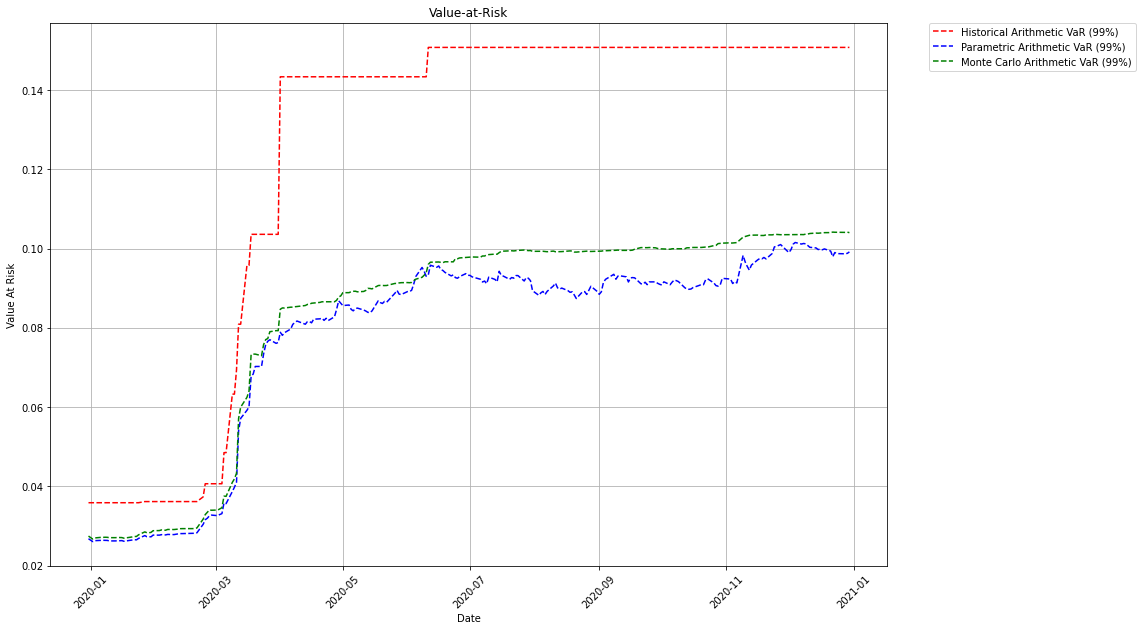

In [21]:
# Plot VaR values against years
plt.figure(figsize=(15,10))
plt.plot(q1_to_3_dataframe['Date'],q1_to_3_dataframe['Portfolio Arithmetic VaR (Historical)'], 'r--', label='Historical Arithmetic VaR (99%)')
plt.plot(q1_to_3_dataframe['Date'],q1_to_3_dataframe['Portfolio Arithmetic VaR (Parametric)'], 'b--', label='Parametric Arithmetic VaR (99%)')
plt.plot(q1_to_3_dataframe['Date'],q1_to_3_dataframe['Portfolio Arithmetic VaR (Monte Carlo)'], 'g--', label='Monte Carlo Arithmetic VaR (99%)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk')
plt.show()

## **Plot ES**

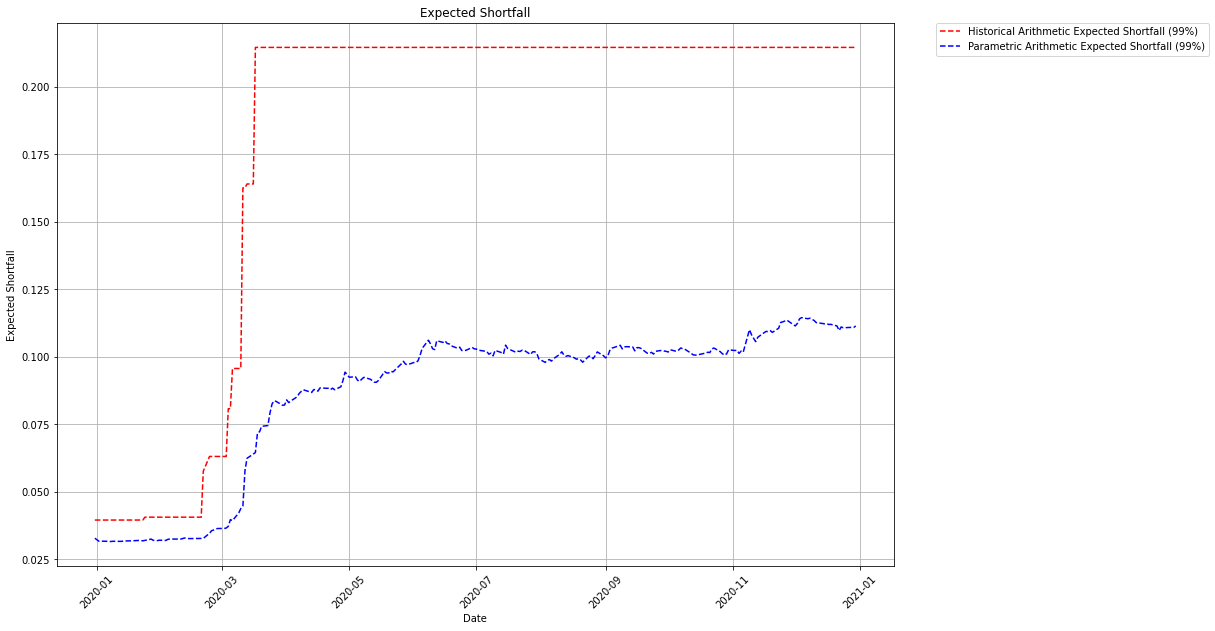

In [22]:
# Plot ES values against years
plt.figure(figsize=(15,10))
plt.plot(q1_to_3_dataframe['Date'], q1_to_3_dataframe['Portfolio Arithmetic ES (Historical)'], 'r--', label='Historical Arithmetic Expected Shortfall (99%)')
plt.plot(q1_to_3_dataframe['Date'], q1_to_3_dataframe['Portfolio Arithmetic ES (Parametric)'], 'b--', label='Parametric Arithmetic Expected Shortfall (99%)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Expected Shortfall')
plt.show()

# Q4: Back Testing

## **Obtain next-day Portfolio Log Returns**

In [23]:
# Copy results dataframe
q4_dataframe = deepcopy(q1_to_3_dataframe)

# View dataframe
q4_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,...,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),Portfolio Arithmetic ES (Historical),Portfolio Arithmetic VaR (Parametric),Portfolio Log VaR (Parametric),Portfolio Arithmetic ES (Parametric),Portfolio Arithmetic VaR (Monte Carlo)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,...,123072.430420,-0.002127,-0.002125,0.035902,0.036562,0.039584,0.026816,0.027182,0.032847,0.027483
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,...,122810.954285,0.011023,0.011084,0.035902,0.036562,0.039584,0.026095,0.026441,0.031713,0.026740
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,...,124172.153473,-0.020511,-0.020302,0.035902,0.036562,0.039584,0.026330,0.026683,0.031778,0.027009
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,...,121651.184082,-0.014681,-0.014574,0.035902,0.036562,0.039584,0.026418,0.026773,0.031710,0.027164
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,...,119878.284454,0.000242,0.000242,0.035902,0.036562,0.039584,0.026425,0.026780,0.031609,0.027163


In [24]:
# Assign next-day Portfolio Log Returns to new column 
q4_dataframe["log_return_nextday"] = q4_dataframe["Portfolio Log Return"].shift(-1)

# Assign 30th December 2020 next day log returns 
q4_dataframe.at[504,'log_return_nextday']= Stock_return.iloc[-1]['Portfolio Log Return'] 

# View dataframe
q4_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,...,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),Portfolio Arithmetic ES (Historical),Portfolio Arithmetic VaR (Parametric),Portfolio Log VaR (Parametric),Portfolio Arithmetic ES (Parametric),Portfolio Arithmetic VaR (Monte Carlo),log_return_nextday
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,...,-0.002127,-0.002125,0.035902,0.036562,0.039584,0.026816,0.027182,0.032847,0.027483,0.011023
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,...,0.011023,0.011084,0.035902,0.036562,0.039584,0.026095,0.026441,0.031713,0.026740,-0.020511
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,...,-0.020511,-0.020302,0.035902,0.036562,0.039584,0.026330,0.026683,0.031778,0.027009,-0.014681
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,...,-0.014681,-0.014574,0.035902,0.036562,0.039584,0.026418,0.026773,0.031710,0.027164,0.000242
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,...,0.000242,0.000242,0.035902,0.036562,0.039584,0.026425,0.026780,0.031609,0.027163,0.014042


## **Plot Log Returns (in Loss) against Log VaR (99%)**

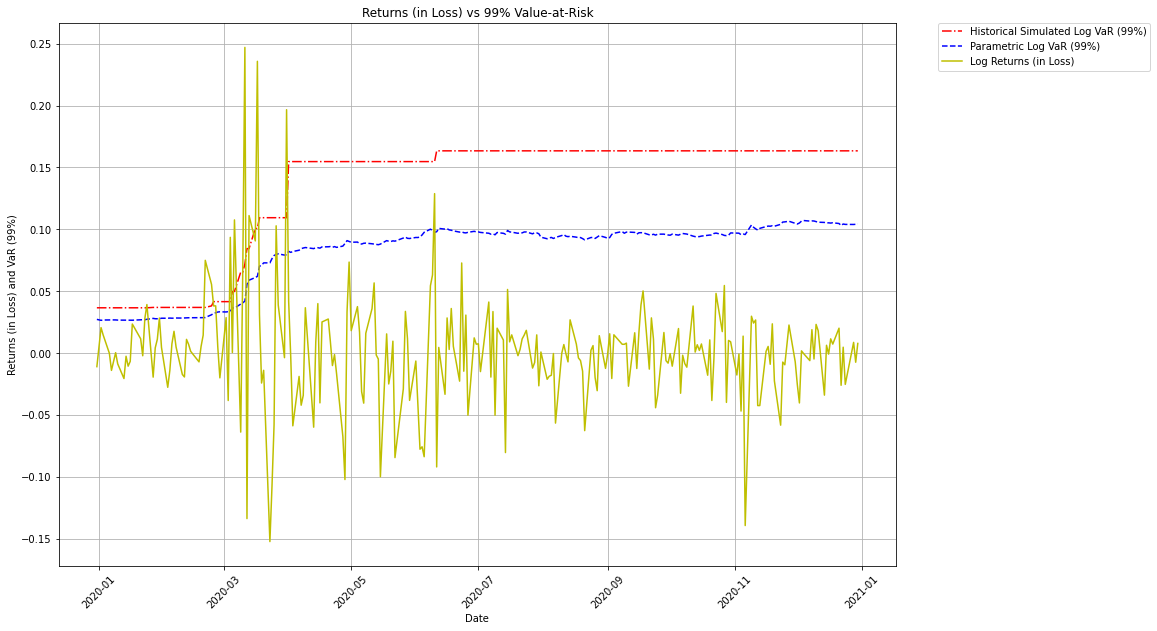

In [25]:
plt.figure(figsize=(15,10))
plt.plot(q4_dataframe['Date'], q4_dataframe['Portfolio Log VaR (Historical)'], 'r-.', label='Historical Simulated Log VaR (99%)')
plt.plot(q4_dataframe['Date'], q4_dataframe['Portfolio Log VaR (Parametric)'], 'b--', label='Parametric Log VaR (99%)')
plt.plot(q4_dataframe['Date'], -q4_dataframe['log_return_nextday'], 'y-', label='Log Returns (in Loss)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR (99%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 99% Value-at-Risk')
plt.show()

## **Bernouli Test**

**Instatantiate backtesting alpha**

In [26]:
# Backtesting Alpha = 0.05
backtesting_alpha = 0.05

**Parametric**

In [27]:
# Observed Level
observed_level = 1 - len(q4_dataframe[-q4_dataframe['Portfolio Log VaR (Parametric)']>q4_dataframe['log_return_nextday']])/len(q4_dataframe)

# Number of Obervations
observations = len(q4_dataframe)

# Number of Faliures: Happens when the VaR is exceeded by negative return (i.e., loss)
failures = len(q4_dataframe[-q4_dataframe['Portfolio Log VaR (Parametric)']>q4_dataframe['log_return_nextday']])

# Expected number of faliures
expected = observations*0.01 

print('################################')
print("General Statistics (Parametric)")
print('################################')
print("VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

################################
General Statistics (Parametric)
################################
VaR 99%
VaR level: 0.99
Observed level: 0.9328063241106719
Observations: 253
Failures: 17
Expected: 2.5300000000000002


In [28]:
# Calculate p value as for one tailed test, but compare it to backtesting_alpha/2 instead since we want a two-tailed test
p_value_99 = 1-binom.cdf(failures-1, observations, 0.01) 
print("P-value of VaR 99%: ", p_value_99)

# Check against backtesting_alpha/2 (two-tailed test)
if(p_value_99 < backtesting_alpha/2):
    print("Reject null hypothesis under binomial distribution")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of VaR 99%:  1.2425909190483253e-09
Reject null hypothesis under binomial distribution


**Historical Stimulation**

In [29]:
# Observed Level
observed_level = 1 - len(q4_dataframe[-q4_dataframe['Portfolio Log VaR (Historical)']>q4_dataframe['log_return_nextday']])/len(q4_dataframe)

# Number of Obervations
observations = len(q4_dataframe)

# Number of Faliures: Happens when the VaR is exceeded by negative return (i.e., loss)
failures = len(q4_dataframe[-q4_dataframe['Portfolio Log VaR (Historical)']>q4_dataframe['log_return_nextday']])

# Expected number of faliures
expected = observations*0.01 

print('###########################################')
print("General Statistics (Historical Simulation)")
print('###########################################')
print("VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))


###########################################
General Statistics (Historical Simulation)
###########################################
VaR 99%
VaR level: 0.99
Observed level: 0.9604743083003953
Observations: 253
Failures: 10
Expected: 2.5300000000000002


In [30]:
# Calculate p value as for one tailed test, but compare it to 0.025 instead
p_value_99 = 1-binom.cdf(failures-1, observations, 0.01) 
print("P-value of VaR 99%: ", p_value_99)

# Check against backtesting_alpha/2 (two-tailed test)
if(p_value_99 < backtesting_alpha/2):
    print("Reject null hypothesis under binomial distribution")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of VaR 99%:  0.0002750336255739061
Reject null hypothesis under binomial distribution


## **Independence Test**
- Calculate using two proportions Z-test

**Historical Simulation**

In [31]:
# Create copy of dataframe
df_hist = deepcopy(q4_dataframe)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
df_hist['ind_t'] = df_hist.apply(lambda row: 1 if -row['Portfolio Log VaR (Historical)']>row['log_return_nextday'] else 0, axis=1)
df_hist['ind_t1'] = df_hist['ind_t'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
df_hist['ind_00'] = df_hist.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
df_hist['ind_10'] = df_hist.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
df_hist['ind_01'] = df_hist.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
df_hist['ind_11'] = df_hist.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

# Drop missing values
df_hist.dropna(inplace=True)

# 'N00' — Number of periods with no failures followed by a period with no failures
# 'N10' — Number of periods with failures followed by a period with no failures
# 'N01' — Number of periods with no failures followed by a period with failures
# 'N11' — Number of periods with failures followed by a period with failures
N00, N10, N01, N11 = df_hist[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)


print(f'N00: {N00}, N10: {N10}, N01: {N01}, N11: {N11}')

N00: 234, N10: 8, N01: 8, N11: 2


In [32]:
# n1: Number of periods with faliures
# n2: Number of periods with no faliures
n1 = len(df_hist[df_hist['ind_t']==1])
n2 = len(df_hist[df_hist['ind_t']==0])

# p1 = Conditional Probability from 1 to 1
# p2 = Conditional Probability from 0 to 1
p1 = N11/n1
p2 = N01/n2
p = n1/(n1+n2)

# Calculate z score using formula
z_score = (p1-p2)/math.sqrt(p*(1-p)*((1/n1)+(1/n2)))

# Calculate p value as for one tailed test, but compare it to 0.025 instead
p_VaR_99 = 1-norm.cdf(z_score, 0, 1) 

print("z score: ", z_score)
print("P-value of VaR 99%: ", p_VaR_99)

if(p_VaR_99 < backtesting_alpha/2):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  2.650124453727507
P-value of VaR 99%:  0.004023106264085197
Reject null hypothesis


#### Parametric 

In [33]:
# Create copy of dataframe
df_para = deepcopy(q4_dataframe)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
df_para['ind_t_p'] = df_para.apply(lambda row: 1 if -row['Portfolio Log VaR (Parametric)']>row['log_return_nextday'] else 0, axis=1)
df_para['ind_t1_p'] = df_para['ind_t_p'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
df_para['ind_00_p'] = df_para.apply(lambda row: 1 if row['ind_t_p']==0 and row['ind_t1_p']==0 else 0, axis=1)
df_para['ind_10_p'] = df_para.apply(lambda row: 1 if row['ind_t_p']==0 and row['ind_t1_p']==1 else 0, axis=1)
df_para['ind_01_p'] = df_para.apply(lambda row: 1 if row['ind_t_p']==1 and row['ind_t1_p']==0 else 0, axis=1)
df_para['ind_11_p'] = df_para.apply(lambda row: 1 if row['ind_t_p']==1 and row['ind_t1_p']==1 else 0, axis=1)

# Drop missing values
df_para.dropna(inplace=True)

# 'N00' — Number of periods with no failures followed by a period with no failures
# 'N10' — Number of periods with failures followed by a period with no failures
# 'N01' — Number of periods with no failures followed by a period with failures
# 'N11' — Number of periods with failures followed by a period with failures
N00_p, N10_p, N01_p, N11_p = df_para[['ind_00_p','ind_10_p','ind_01_p','ind_11_p']].sum(axis=0)

print(f'N00: {N00_p}, N10: {N10_p}, N01: {N01_p}, N11: {N11_p}')


N00: 225, N10: 10, N01: 10, N11: 7


In [34]:
# n1: Number of periods with faliures
# n2: Number of periods with no faliures
n1_p = len(df_para[df_para['ind_t_p']==1])
n2_p = len(df_para[df_para['ind_t_p']==0])

# p2 = Probability of having a failure on period t, given that there was no failure on period t–1
# p1 = Probability of having a failure on period t, given that there was a failure on period t–1
p2_p = N01_p/n2_p
p1_p = N11_p/n1_p
p_p = n1_p/(n1_p+n2_p)


# Calculate z score using formula
z_score_p = (p1_p-p2_p)/math.sqrt(p_p*(1-p_p)*((1/n1_p)+(1/n2_p)))

# Calculate p value as for one tailed test, but compare it to 0.025 instead
p_VaR_99_p = 1-norm.cdf(z_score_p, 0, 1)
 
print("z score: ", z_score_p)
print("P-value of VaR 99%: ", p_VaR_99_p)
if(p_VaR_99_p < backtesting_alpha/2):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  5.861051089592396
P-value of VaR 99%:  2.2997321824647088e-09
Reject null hypothesis


#### Q4 Answer: I would define a better model as one that, by backtesting methods, does not reject the null hypothesis that the probability of exceptions on any given day is 0.01. However, in this case, the null hypothesis has been rejected for both historical and parametric models, thus we can judge the model based on the number of failiures and by its p value. Comparing the number of faliures for historical simulation (10 out of 253) with parametric estimation (17 out of 253), the Historical Simulation method seems to be better with a lower number of faliures and a higher observed level, meaning the model is better at estimating VaR such that the probability of exceptions on any given day is close to 0.01. The two-tailed p value for Historical Simulation is also larger and closer to 0.05 (backtesting alpha), which is the threshold above which we do not reject the null hypothesis. Thus, overall, the Historical Simulation model seems to be a better model.

# Q5

## **Method: Weight the more recent data more heavily**

**Find VaR Values**

In [35]:
var_values = []
var_log_values = []
weight = 0.99

for i in range(252,505): # Rolling Window
    # Obtain data for past 250 days, inclusive of focal day
    sample = Stock_return[i-250:i] 

    # Assign 0 to most recent data, 249 to least recent data 
    sample['Recency'] = sorted(list(range(0,250)), reverse=True) 

    # Assume weight is 0.99, weight**recency (Weight more recent data heavier )
    sample['Weighted'] = weight ** sample['Recency'] 

    # Normalise the weights
    sample['Adjusted'] = sample['Weighted']/sample['Weighted'].sum()

    # Sort the sample to get the percentile
    sample_sorted = sample.sort_values('Portfolio Log Return', ascending = False)
    sample_sorted['cumsum'] = sample_sorted['Adjusted'].cumsum()

    var_log_values.append(-sample_sorted[sample_sorted['cumsum']>=0.99]['Portfolio Log Return'].values[0]) # Store log VaR
    var_values.append(-(np.exp(sample_sorted[sample_sorted['cumsum']>=0.99]['Portfolio Log Return'].values[0])-1)) # Store Arithmetic VaR


In [36]:
# Create dataframe from 31/12/19 till 30/12/20
q5_dataframe = Stock_return[251:-1]

q5_dataframe['Portfolio Arithmetic VaR (Historical)'] = var_values # Store Arithmetic VaR
q5_dataframe['Portfolio Log VaR (Historical)'] = var_log_values # Store log VaR

# View Dataframe
q5_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical)
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,122810.954285,0.117976,0.472911,0.409113,123072.430420,-0.002127,-0.002125,0.036088,0.036755
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,124172.153473,0.119345,0.472206,0.408450,122810.954285,0.011023,0.011084,0.036088,0.036755
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,121651.184082,0.120634,0.473991,0.405376,124172.153473,-0.020511,-0.020302,0.036088,0.036755
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,119878.284454,0.123393,0.477687,0.398920,121651.184082,-0.014681,-0.014574,0.035708,0.036361
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,119907.328033,0.122783,0.477157,0.400060,119878.284454,0.000242,0.000242,0.035708,0.036361


**Get next day log returns**

In [37]:
# Get next day Log Returns
q5_dataframe["log_return_nextday"] = q5_dataframe["Portfolio Log Return"].shift(-1)

# Assign 30th Dec 20 next day log returns
q5_dataframe.at[504,'log_return_nextday']= Stock_return.iloc[-1]['Portfolio Log Return']

# View dataframe
q5_dataframe.head(5)

,Date,aapl Adj Close,dal Adj Close,ccl Adj Close,aapl Log Return,dal Log Return,ccl Log Return,aapl Value,dal Value,ccl Value,Portfolio Value,aapl Weight,dal Weight,ccl Weight,Portfolio Prev Value,Portfolio Log Return,Portfolio Percentage Return,Portfolio Arithmetic VaR (Historical),Portfolio Log VaR (Historical),log_return_nextday
252,2019-12-31,72.443558,58.078648,50.243595,0.007280,-0.003073,-0.003731,14488.711548,58078.647614,50243.595123,122810.954285,0.117976,0.472911,0.409113,123072.430420,-0.002127,-0.002125,0.036088,0.036755,0.011023
253,2020-01-02,74.096451,58.634808,50.718056,0.022560,0.009530,0.009399,14819.290161,58634.807587,50718.055725,124172.153473,0.119345,0.472206,0.408450,122810.954285,0.011023,0.011084,0.036088,0.036755,-0.020511
254,2020-01-03,73.376083,57.661533,49.314434,-0.009770,-0.016738,-0.028065,14675.216675,57661.533356,49314.434052,121651.184082,0.120634,0.473991,0.405376,124172.153473,-0.020511,-0.020302,0.036088,0.036755,-0.014681
255,2020-01-06,73.960762,57.264275,47.821857,0.007937,-0.006913,-0.030734,14792.152405,57264.274597,47821.857452,119878.284454,0.123393,0.477687,0.398920,121651.184082,-0.014681,-0.014574,0.035708,0.036361,0.000242
256,2020-01-07,73.612930,57.214619,47.970123,-0.004714,-0.000868,0.003096,14722.586060,57214.618683,47970.123291,119907.328033,0.122783,0.477157,0.400060,119878.284454,0.000242,0.000242,0.035708,0.036361,0.014042


**Plot Returns (in loss) and HS VaR**

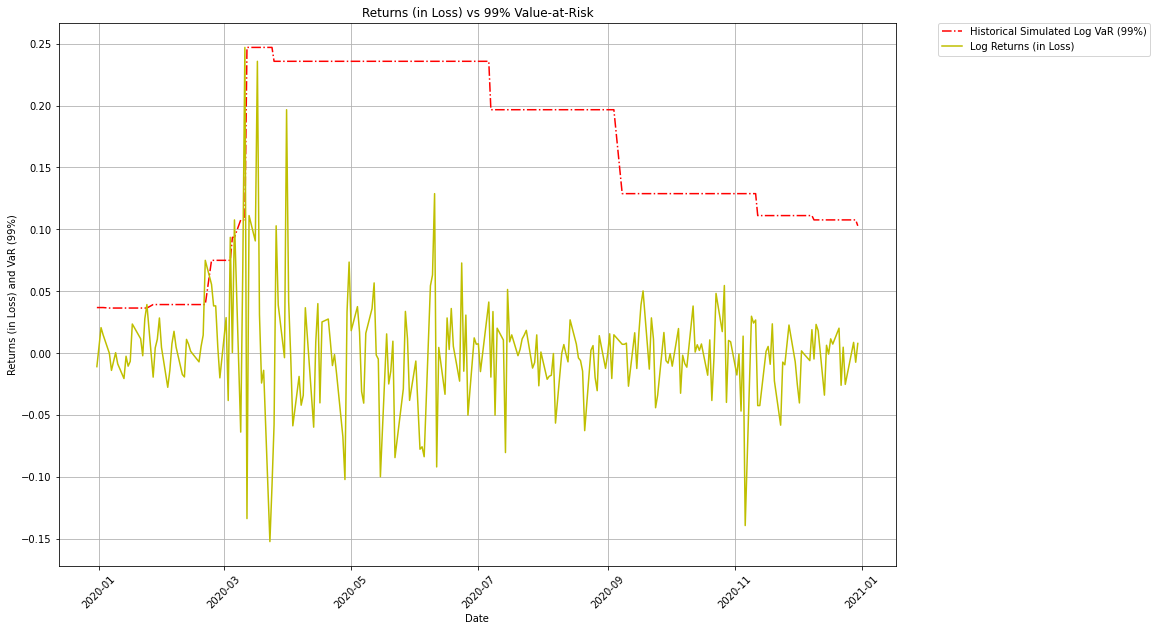

In [38]:
plt.figure(figsize=(15,10))
plt.plot(q5_dataframe['Date'], q5_dataframe['Portfolio Log VaR (Historical)'], 'r-.', label='Historical Simulated Log VaR (99%)')
plt.plot(q5_dataframe['Date'], -q5_dataframe['log_return_nextday'], 'y-', label='Log Returns (in Loss)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR (99%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 99% Value-at-Risk')
plt.show()

**Bernouli Test**

In [39]:
# Observed Level
observed_level = 1 - len(q5_dataframe[-q5_dataframe['Portfolio Log VaR (Historical)']>q5_dataframe['log_return_nextday']])/len(q5_dataframe)

# Number of Obervations
observations = len(q5_dataframe)

# Number of Faliures: Happens when the VaR is exceeded by negative return (i.e., loss)
failures = len(q5_dataframe[-q5_dataframe['Portfolio Log VaR (Historical)']>q5_dataframe['log_return_nextday']])

# Expected number of faliures
expected = observations*0.01 

print('###########################################')
print("General Statistics (Historical Simulation)")
print('###########################################')
print("VaR 99%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

###########################################
General Statistics (Historical Simulation)
###########################################
VaR 99%
VaR level: 0.99
Observed level: 0.9802371541501976
Observations: 253
Failures: 5
Expected: 2.5300000000000002


In [40]:
# Calculate p value as for one tailed test, but compare it to 0.025 instead
p_value_99 = 1-binom.cdf(failures-1, observations, 0.01) 
print("P-value of VaR 99%: ", p_value_99)

# Check against backtesting_alpha/2 (two-tailed test)
if(p_value_99 < backtesting_alpha/2):
    print("Reject null hypothesis under binomial distribution")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of VaR 99%:  0.11185872560184484
Not enough evidence to reject null at 0.05 backtesting significance level under binomial distribution


**Independence Test**

In [41]:
# Create copy of dataframe
df_hist = deepcopy(q5_dataframe)

# ind_t: indicate whether exception at t; 
# ind_t1: indicate whether exception at t-1
df_hist['ind_t'] = df_hist.apply(lambda row: 1 if -row['Portfolio Log VaR (Historical)']>row['log_return_nextday'] else 0, axis=1)
df_hist['ind_t1'] = df_hist['ind_t'].shift(1)

# 'ind_00' — indicate periods with no failures followed by a period with no failures
# 'ind_10' — indicate periods with failures followed by a period with no failures
# 'ind_01' — indicate periods with no failures followed by a period with failures
# 'ind_11' — indicate periods with failures followed by a period with failures
df_hist['ind_00'] = df_hist.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
df_hist['ind_10'] = df_hist.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
df_hist['ind_01'] = df_hist.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
df_hist['ind_11'] = df_hist.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

# Drop missing values
df_hist.dropna(inplace=True)

# 'N00' — Number of periods with no failures followed by a period with no failures
# 'N10' — Number of periods with failures followed by a period with no failures
# 'N01' — Number of periods with no failures followed by a period with failures
# 'N11' — Number of periods with failures followed by a period with failures
N00, N10, N01, N11 = df_hist[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)


print(f'N00: {N00}, N10: {N10}, N01: {N01}, N11: {N11}')

N00: 242, N10: 5, N01: 5, N11: 0


In [42]:
# n1: Number of periods with faliures
# n2: Number of periods with no faliures
n1 = len(df_hist[df_hist['ind_t']==1])
n2 = len(df_hist[df_hist['ind_t']==0])

# p1 = Conditional Probability from 1 to 1
# p2 = Conditional Probability from 0 to 1
p1 = N11/n1
p2 = N01/n2
p = n1/(n1+n2)

# Calculate z score using formula
z_score = (p1-p2)/math.sqrt(p*(1-p)*((1/n1)+(1/n2)))

# Calculate p value as for one tailed test, but compare it to 0.025 instead
p_VaR_99 = 1-norm.cdf(z_score, 0, 1) 

print("z score: ", z_score)
print("P-value of VaR 99%: ", p_VaR_99)

if(p_VaR_99 < backtesting_alpha/2):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  -0.3213463130847681
P-value of VaR 99%:  0.6260260184194575
Not enough evidence to reject null 0.05 backtesting significance level under normal distribution 


#### Q5 Answer: I would define a better model as one that, by backtesting methods, does not reject the null hypothesis that the probability of exceptions on any given day is 0.01. By weighting the more recent data heavily, we obtain a conclusion that does not reject the null hypothesis for both the Bernouli and Independence test, meaning the model is better at estimating VaR such that the probability of exceptions on any given day is 0.01 as compared to the original HS model which rejected the null hypothesis for both tests. Looking at the number of failures, this model also gives a lower number of faliures (5 out of 253) as compared to the original HS model (10 out of 253). Thus, overall, the Historical Simulation model with higher weights on recent data seems to be a better model.